In [14]:
import sys
import json
import time
import pathlib
from copy import deepcopy
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from agent_model import AgentModel
from agent_model.util import parse_data, plot_agent, plot_b2_data

data_files_path = pathlib.Path('data_files')
b2_data_path = pathlib.Path('simoc_server/test/b2_data_files')

In [15]:
with open(data_files_path / 'agent_desc.json') as f:
    agent_desc = json.load(f)
with open(data_files_path / 'agent_conn.json') as f:
    agent_conn = json.load(f)
with open(data_files_path / 'currency_desc.json') as f:
    currency_desc = json.load(f)

## Generate `b2_sun` Data
Outputs of the cell below, `hourly_par` and `monthly_par`, are hardcoded into `custom_function.b2_sun`.

Saving to hourly_par.csv (n=24), monthly_par.csv (n=60)


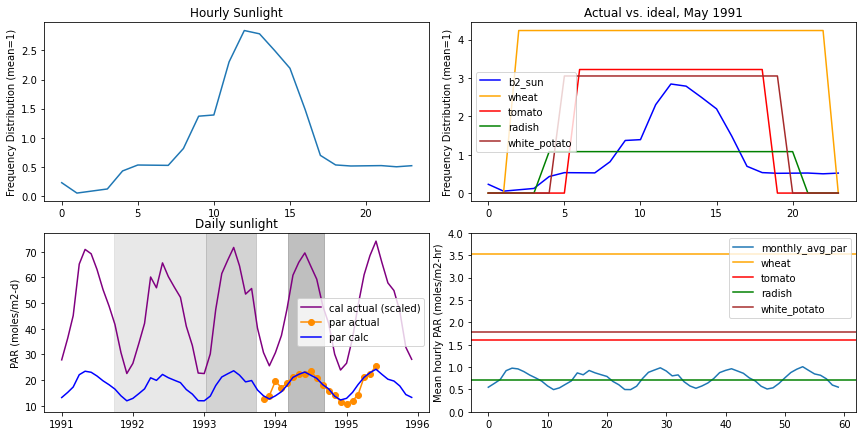

In [16]:
# Sun Agent

# Hourly PAR (moles/m2-s) for December 24, 1993 to December 28, 1993 are provided
# in Marino Figure 2b from inside IAB. Read in with inferred timestamps.
daily_light = pd.read_csv(b2_data_path / 'marino_figure2b_data.csv', header=None)
daily_light['timestamp'] = pd.to_datetime('December 24, 1993 00:00:00')
daily_light['timedelta'] = daily_light[0].apply(lambda d: timedelta(days=d))
daily_light['timestamp'] += daily_light['timedelta']
# Calculate mean values by hour across 4 sample days.
hourly_par = [None] * 24
for i in range(24):
    in_range = daily_light['timestamp'].dt.hour == i
    if sum(in_range) > 0:
        hourly_par[i] = daily_light.loc[in_range, 1].mean()
# Interpolate hours with no timestamps
for i in range(len(hourly_par)):
    if hourly_par[i] == None:
        hourly_par[i] = (hourly_par[i-1] + hourly_par[i+1])/2
# Scale to mean = 1
hourly_par /= (sum(hourly_par) / len(hourly_par))

# Monthly sunlight (cal/cm2) for January 1991 to December 1995 is provided 
# in Marino Figure 4 from LANGLEY. Read in and timestamp e.g. '01-01-1991 00:00:00'
raw_4 = pd.read_csv('simoc_server/test/b2_data_files/marino_figure4_data.csv', header=None)
months = pd.date_range(start='12/31/1990', periods=60, freq='M')
months += timedelta(days=1)
df = pd.DataFrame()
df['cal_per_m2'] = raw_4[1]
df.set_index(months, inplace=True)

# Weekly PAR inside B2 (moles/m2-d) for November 1993 to May 1995 are provided
# in Marino Figure 2c from inside IAB. Read in with inferred (irregular) timestamps.
raw_2c = pd.read_csv('simoc_server/test/b2_data_files/marino_figure2c_data.csv', header=None)
raw_2c['timestamp'] = pd.to_datetime('November 1, 1993')
raw_2c['timestamp'] += raw_2c[0].apply(timedelta)
# For monthly timesteps (above), calculate mean PAR for timestep +-15 days
df['mean_daily_par'] = None
for i in range(1, df.shape[0]-2):
    ref_date = df.index[i]
    start_date = ref_date - timedelta(days=15)
    end_date = ref_date + timedelta(days=15)
    i_samples = (raw_2c['timestamp'] >= start_date) & (raw_2c['timestamp'] < end_date)
    if sum(i_samples) > 0:
        mean_par = raw_2c.loc[i_samples, 1].mean()
        df.loc[ref_date, 'mean_daily_par'] = mean_par

# Use a y=mx+b linear fit to extrapolate monthly PAR based on Calories
def linear_curve(x, m, b):
    return m * x + b
ref = df.dropna(axis=0)
x_data = ref['cal_per_m2'].to_numpy()
y_data = ref['mean_daily_par'].to_numpy()
params, params_covariance = curve_fit(linear_curve, x_data, y_data)
m, b = params
df['daily_par_by_month'] = df['cal_per_m2'] * m + b
monthly_par = df['daily_par_by_month'].to_numpy() / 24

print(f'Saving to hourly_par.csv (n={len(hourly_par)}), '
      f'monthly_par.csv (n={len(monthly_par)})')
pd.DataFrame(hourly_par).to_csv(b2_data_path / 'hourly_par.csv')
pd.DataFrame(monthly_par).to_csv(b2_data_path / 'monthly_par.csv')

# VISUALIZE
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
fig.tight_layout()
ref_species = (('wheat', 'orange'), ('tomato', 'red'),
               ('radish', 'green'), ('white_potato', 'brown'))

# Plot daily curve
axs[0][0].plot(hourly_par)
axs[0][0].set_title('Hourly Sunlight')
axs[0][0].set_ylabel('Frequency Distribution (mean=1)')

# Compare May 1 1991 sunlight to ideal
may_1_par = np.array(hourly_par) * monthly_par[4]
axs[0][1].plot(hourly_par, color='blue', label='b2_sun')
axs[0][1].set_title('Actual vs. ideal, May 1991')
axs[0][1].set_ylabel('Frequency Distribution (mean=1)')
for species, color in ref_species:
    for char in agent_desc['plants'][species]['data']['characteristics']:
        if char['type'] == 'par_baseline':
            par_baseline = char['value']
        elif char['type'] == 'photoperiod':
            photoperiod = char['value']
    photo_start = 12 - (photoperiod // 2)
    photo_end = photo_start + photoperiod
    photo_rate = (par_baseline * 24) / photoperiod
    output = [0 if (i < photo_start or i > photo_end) else photo_rate
              for i in range(24)]
    axs[0][1].plot(output, color=color, label=species)
axs[0][1].legend()

#     axs[1][1].axhline(char['value'], label=f'{species} ideal', color=color)

# Plot calculated vs refs
axs[1][0].plot(df['cal_per_m2'] * 0.1, label='cal actual (scaled)', color='purple')
axs[1][0].plot(df['mean_daily_par'], label='par actual', marker='o', color='darkorange')
axs[1][0].plot(df['daily_par_by_month'], label='par calc', color='blue')
axs[1][0].set_title('Daily sunlight')
axs[1][0].set_ylabel('PAR (moles/m2-d)')
axs[1][0].legend()
m1a_start = '1991-09-26'
m1b_start = '1993-01-12'  # Day 475, pure O2 added
m1_end = '1993-09-25'  # 730 Days
m2_start = '1994-03-06'
m2_end = '1994-09-06'
axs[1][0].axvspan(m1a_start, m1b_start, alpha=0.5, color='lightgray', label='mission 1a')
axs[1][0].axvspan(m1b_start, m1_end, alpha=0.5, color='darkgray', label='mission 1b')
axs[1][0].axvspan(m2_start, m2_end, alpha=0.5, color='gray', label='mission 2')


# Plot hourly vs plant ideals
# Plot results
axs[1][1].plot(monthly_par, label='monthly_avg_par')
axs[1][1].set_ylabel('Mean hourly PAR (moles/m2-hr)')
axs[1][1].set_ylim([0, 4])
for species, color in ref_species:
    for char in agent_desc['plants'][species]['data']['characteristics']:
        if char['type'] == 'par_baseline':
            axs[1][1].axhline(char['value'], label=f'{species}', color=color)
axs[1][1].legend()

## Biomes

In [25]:
# Structures: habitat_b2, greenhouse_b2, b2_biomes, test
# Air Volume taken from Silverstone and Nelson, 'Food Production..' Table 1
structures_desc = {}
AIR_DENSITY = 1.25
new_structures = {
    'greenhouse_b2': {'category': 'greenhouse', 'volume': 35_220,
        'description': 'The Intensive Agricultural Biome at Biosphere 2'},
    'crew_habitat_b2': {'category': 'habitat', 'volume': 10_997,
        'description': 'The crew habitat at Biosphere 2'},
    'b2_biomes': {'category': 'biome', 'volume': 28_900 + 41_600 + 17_600 + 15_000 + 15_000,
        'description': 'The Rainforest, Savannah/ocean, Desert, West Lung, South Lung of Biosphere 2'},
}
for name, details in new_structures.items():
    capacity_chars = [{
        'type': f'capacity_{gas}', 'value': details['volume'] * AIR_DENSITY, 'unit': 'kg',
    } for gas in ['h2', 'h2o', 'ch4', 'o2', 'n2', 'co2']]
    structures_desc[name] = {
        'description': details['description'],
        'data': {
            'input': [],
            'output': [],
            'characteristics': [
                {'type': 'category', 'value': details['category']},
                {'type': 'volume', 'value': details['volume']},
                *capacity_chars
            ],
        },
    }
# Connect new structures to the atmosphere equalizer
structures_conn = []
first_struct = next(iter(new_structures.keys()))
if not any(conn['from'] == f'{first_struct}.atmosphere' for conn in agent_conn):
    for struct in new_structures.keys():
        structures_conn.append(
            {'from': f'{struct}.atmosphere', 
             'to': 'atmosphere_equalizer.atmosphere'})
            
# Soil: exchanges from Severinghaus Table 1 (kmoles, 9/26/91 - 6/7/93),
# volume from Silverstone and Nelson, 'Food Production..' Table 1.
# TODO: Balance respiration with in['organic_matter'] and out['h2o'](internal)
soil_exchanges = dict(o2=-708, co2=662)  # kmoles
molar_mass = dict(o2=15.999, co2=44.01)
soil_volume = {'greenhouse_b2': 2720, 'b2_biomes': 6000 + 4000 + 4000}  # Rainforest, savannah/ocean, desert
start_time, end_time = datetime(1991, 9, 26), datetime(1993, 6, 7)
hours = (end_time - start_time).total_seconds() / 3600
o2_input = -soil_exchanges['o2'] * molar_mass['o2'] / sum(soil_volume.values()) / hours
co2_output = soil_exchanges['co2'] * molar_mass['co2'] / sum(soil_volume.values()) / hours
structures_desc['soil'] = {
    'description': 'One cubic meter of soil in Biosphere 2',
    'data': {
        'input': [{'type': 'o2', 'value': o2_input, 'flow_rate': {'unit': 'kg', 'time': 'hour'}}],
        'output': [{'type': 'co2', 'value': co2_output, 'flow_rate': {'unit': 'kg', 'time': 'hour'}}],
        'characteristics': [{'type': 'volume', 'value': 1, 'unit': 'm^3'}],
    },
}
if not any(conn['to'] == 'soil.o2' for conn in agent_conn):
    structures_conn += [{'from': 'greenhouse.o2', 'to': 'soil.o2'},
                        {'from': 'soil.co2', 'to': 'greenhouse.co2'}]
        

greenhouse_b2


## Update `data_files`

In [22]:
# Sun agent: func, graphs/charts, csv, custom_func, test
agent_desc['structures']['b2_sun'] = {
  "description": "Sunlight available to plants in the greenhouse_b2",
  "data": {
        "input": [],
        "output": [],
        "characteristics": [
          {"type": "par_baseline", "value": 1, "unit": "mol/m2-hr"},
          {"type": "capacity_par", "value": 5, "unit": "mol"},
          {"type": "custom_function", "value": "b2_sun"},
        ]
      },
}

agent_desc['structures'] = {**agent_desc['structures'], **structures_desc}
agent_conn += structures_conn

# Plant.par conections: add sun as priority=0 (top), change lamp to priority=1
for i, conn in enumerate(agent_conn):
    if conn['from'] == 'lamp.par' and conn['to'] != 'lamp.par':
        agent_conn[i]['priority'] = 1
        if agent_conn[i+1]['from'] != 'b2_sun.par':
            agent_conn.insert(i+1, {'from': 'b2_sun.par', 'to': conn['to'], 'priority': 0})
            
# Add density_factor to plant agents
default_density_factor = 1
default_crop_management_factor = 1
for plant, plant_desc in agent_desc['plants'].items():    
    
    # Add weight to biomass_output
    index, output = next(((i, o) for i, o in enumerate(plant_desc['data']['output'])
                         if o['type'] == 'biomass'))
    weights = output['weighted']
    if 'density_factor' not in weights:
        agent_desc['plants'][plant]['data']['output'][index]['weighted'].append('density_factor')
    if 'crop_management_factor' not in weights:
        agent_desc['plants'][plant]['data']['output'][index]['weighted'].append('crop_management_factor')

    # Add default as a characteristic
    if not any(char['type'] == 'density_factor' for char in plant_desc['data']['characteristics']):
        agent_desc['plants'][plant]['data']['characteristics'].append(
            {'type': 'density_factor', 'value': 1})
    if not any(char['type'] == 'crop_management_factor' for char in plant_desc['data']['characteristics']):
        agent_desc['plants'][plant]['data']['characteristics'].append(
            {'type': 'crop_management_factor', 'value': 1})
        

# Concrete: exchange from Severinghaus 1
# TODO: Absorbtion rate should be proportional to ambient CO2
# TODO: Separate by biome/structure, connect to each atmosphere
# TODO: Balance equation with in['CaOH2'](stored), out['CaCO3', 'h2o'](internal)
concrete_exchanges = dict(co2=-550)
concrete_exposed_area = {
    'structural': 13000,
    'unpainted_artificial_rock': 2800,
}
co2_input = -concrete_exchanges['co2'] * molar_mass['co2'] / sum(concrete_exposed_area.values()) / hours
agent_desc['structures']['concrete'] = {
    'description': '1 m^2 of exposed calcifying concrete',
    'data': {
        "input": [{"type": "co2", "value": co2_input, "flow_rate": {'unit': 'kg', 'time': 'hour'}, 
                   "weighted": ['calcification_rate']}],
        "output": [],
        "characteristics": [
            {"type": "area", "value": 1, "unit": "m^2"},
            {"type": "custom_function", "value": "concrete"}]
    },
}
if not any(c['to'] == 'concrete.co2' for c in agent_conn):
    agent_conn.append({'from': 'greenhouse.co2', 'to': 'concrete.co2'})

    
# b2_power_gen: an agent which generates virtually unlimited kwh to represent
# the b2 power plant. This currency/agent will not be featured, but is
# required to re-use agents from the base SIMOC-MARS config which use kwh.
agent_desc['power_generation']['b2_power_gen'] = {
    'description': 'The Biosphere 2 power generation facility',
    'data': {
        'input': [],
        'output': [{'type': 'kwh', 'value': 1000, 'flow_rate': {'unit': 'kWh', 'time': 'hour'}}],
        'characteristics': [{'type': 'category', 'value': 'power'}],
    },
}
if not any(c['from'] == 'b2_power_gen.kwh' for c in agent_conn):
    agent_conn.append({'from': 'b2_power_gen.kwh', 'to': 'power_storage.kwh'})


# o2_makeup_valve, o2_storage: copy CO2 system
agent_desc['eclss']['o2_makeup_valve'] = {
    'description': 'Add O2 gas from o2_storage back into connected structure',
    'data': {
        'input': [{'type': 'o2', 'value': 0.085, 'flow_rate': {'unit': 'kg', 'time': 'hour'},
                   'required': 'mandatory', 
                   'criteria': {'name': 'o2_ratio_out', 'limit': '<', 'value': 0.2}}],
        'output': [{'type': 'o2', 'value': 0.085, 'flow_rate': {'unit': 'kg', 'time': 'hour'},
                    'requires': ['o2']}],
        'characteristics': [],
    },
}
agent_desc['eclss']['o2_storage'] = {
    'description': 'Pressurized O2 storage',
    'data': {
        'input': [],
        'output': [],
        'characteristics': [{'type': 'capacity_o2', 'value': 100_000, 'unit': 'kg'}]
    },
}
if not any(c['from'] == 'o2_storage.o2' for c in agent_conn):
    agent_conn += [{'from': 'o2_storage.o2', 'to': 'o2_makeup_valve.o2'},
                   {'from': 'o2_makeup_valve.o2', 'to': 'greenhouse.o2'}]

# co2 scrubber and storage: connect to greenhouse by default, else habitat
for i, conn in enumerate(agent_conn):
    if conn['from'] == 'habitat.co2' and conn['to'] == f'co2_removal_SAWD.co2':
        conn['priority'] = 1
        if agent_conn[i+1]['from'] != 'greenhouse.co2':
            agent_conn.insert(i+1, {'from': 'greenhouse.co2', 'to': conn['to'], 'priority': 0})
    elif conn['to'] == 'habitat.co2' and conn['from'] == f'co2_makeup_valve.co2':
        conn['priority'] = 1
        if agent_conn[i+1]['to'] != 'greenhouse.co2':
            agent_conn.insert(i+1, {'to': 'greenhouse.co2', 'from': conn['from'], 'priority': 0})

In [23]:
# Update currency_desc
# Crops added for b2 don't have nutrition data yet. The exchanges were
# copied from reference crops, so here nutrition is also copied.
crop_references = {
    'corn': 'wheat',
    'orchard': 'tomato,radish,strawberry',
    'sorghum': 'wheat',
    'vegetables': 'lettuce,spinach,chard',
}
for target, refs in crop_references.items():
    nutrition = dict(kcal=0, water=0, protein=0, carbohydrate=0, fat=0)
    ref_crops = refs.split(',')
    for crop in ref_crops:
        ref = currency_desc['food'][crop]['nutrition']
        nutrition = {k: v + ref[k] for k, v in nutrition.items()}
    nutrition = {k: round(v/len(ref_crops)) for k, v in nutrition.items()}
    currency_desc['food'][target]['source'] = refs
    currency_desc['food'][target]['nutrition'] = nutrition

In [24]:
with open(data_files_path / 'agent_desc.json', 'w') as f:
    json.dump(agent_desc, f, indent=2)
    f.write('\n')
with open(data_files_path / 'agent_conn.json', 'w') as f:
    json.dump(agent_conn, f, indent=4)
with open(data_files_path / 'currency_desc.json', 'w') as f:
    json.dump(currency_desc, f, indent=4)

## Generate `config_b2_base` and custom `agent_desc`

In [7]:
def volume(target, amount=1):
    """Helper function to return volume from agent_desc for agent"""
    for agents_by_class in agent_desc.values():
        for agent, agent_data in agents_by_class.items():
            if agent == target:
                for char in agent_data['data']['characteristics']:
                    if char['type'] == 'volume':
                        return char['value'] * amount
                    
# Adapted agent_model.util
def calc_air_storage(volume):
    # 1 m3 of air weighs ~1.25 kg (depending on temperature and humidity)
    AIR_DENSITY = 1.25  # kg/m3
    # convert from m3 to kg
    mass = volume * AIR_DENSITY
    # atmosphere component breakdown
    percentages = {
        "o2": 18.75,  # estimated from Severinghaus Figure 1
        "co2": 0.04,  # estimated from Severinghaus Figure 1
        "h2o": 1,     # water vapor (simoc default)
        "n2": 80.21,  # nitrogen (remainder of 100%)
    }
    # calculate the mass for each element
    return dict({label: mass*perc/100 for label, perc in percentages.items()},
                total_capacity=dict(value=mass, unit='kg'))

# Greenhouse Layout
# The B2 mission greenhouse plots mapped to SIMOC agents and areas
greenhouse_reference = [
    # SIMOC agent, Mission 2 Area, B2 Reference, B2 Plots
    ('rice', 69 + 89 + 15 + 42, 'Rice/Azalia/Tilapia, Rice, Upland Rice', '1, 10, 15, 10a'),
    ('wheat', 56 + 94, 'Wheat', '1, 13'),
    ('sorghum', 55 + 51, 'Sorghum', '3, 17b'),
    ('peanut', 22 + 46, 'Peanut', '4a, 18a'),
    ('corn', 23 + 88 + 41 + 46, 'Corn', '4b, 12, 16b, 18b'),
    ('dry_bean', 40 + 50, 'Beans', '5, 8'),
    ('sweet_potato', 52 + 54, 'Sweet Potato', '6, 7'),
    ('vegetables', 60 + 81, 'Vegetables', '9, 14'),
    ('soybean', 81 + 51, 'Soybeans', '11, 17a'),
    ('orchard', 262, 'Orchard', 'O')
]
# SCALE AREAS
# Actual total growing area is 3600-3800 m2 (Biosphere 2 Agriculture, Nelson 1993)
# The areas above sum to 1500. Multiply by factor below to makeup difference with
# same crop layout.
# TODO: Redo crop layouts, add banana & papaya based on the article cited above.
area_multiplier = 3700/1500
greenhouse_layout = {crop: round(area*area_multiplier)
                     for (crop, area, *args) in greenhouse_reference}
print('Total Greenhouse Area:', sum(p for p in greenhouse_layout.values()))

# B2 BASE
config_b2_base = {
    # Default fields
    'priorities': ['structures', 'storage', 'power_generation', 'inhabitants',
                   'eclss', 'plants'],
    'seed': 12345,
    'global_entropy': 0,
    'location': 'earth',
    'minutes_per_step': 60,
    'single_agent': 1,

    # Adjustable Fields
    'start_time': '1991-01-01',
    'termination': [{'condition': 'time', 'value': 100, 'unit': 'day',}],
    'agents': {

        # Inhabitants
        'human_agent': {'amount': 8},

        # ECLSS
        'solid_waste_aerobic_bioreactor': {'amount': 1},
        'urine_recycling_processor_VCD': {'amount': 1},
        'multifiltration_purifier_post_treatment': {'amount': 50},
        'co2_removal_SAWD': {'amount': 5},
        'dehumidifier': {'amount': 50},
        'o2_makeup_valve': {'amount': 180},

        # Plants
        **{crop: {'amount': amount} for crop, amount in greenhouse_layout.items()},

        # Structures
        'greenhouse_b2': calc_air_storage(volume('greenhouse_b2')),
        'crew_habitat_b2': calc_air_storage(volume('crew_habitat_b2')),
        'b2_biomes': calc_air_storage(volume('b2_biomes')),
        'atmosphere_equalizer': {'amount': 1},
        'b2_sun': {'amount': 1},
        'concrete': {'amount': 13_000 + 2_800},  # m2 exposed, Structural + Artificial Rock
        'soil': {'amount': 2_720 + 6_000 + 4_000 + 4_000},  # Agriculture + Rainforest + Savannah/Ocean + Desert
        'b2_power_gen': {'amount': 1},

        # Storage
        'water_storage': {'amount': 50, 'potable': 10_000},
        'nutrient_storage': {'amount': 50, "fertilizer": 10_000},
        'food_storage': {'amount': 1},
        'ration_storage': {'amount': 1, 'ration': 500},
        'co2_storage': {'amount': 1, 'co2': 0},
        'o2_storage': {'amount': 1, 'o2': 0},
        'power_storage': {'amount': 10, 'kwh': 1000}
    }
}
with open(data_files_path / 'config_b2_base.json', 'w') as f:
    json.dump(config_b2_base, f, indent=4)
    f.write('\n')

Total Greenhouse Area: 3620


In [8]:
# Custom agent_desc for b2
# Restrict human food
human_desc = deepcopy(agent_desc['inhabitants']['human_agent'])
for i, flow in enumerate(human_desc['data']['input']):
    if flow['type'] == 'food':
        human_desc['data']['input'][i]['value'] *= 0.5  # ADJUST
# Reset target co2 level
sawd_desc = deepcopy(agent_desc['eclss']['co2_removal_SAWD'])
for i, flow in enumerate(sawd_desc['data']['input']):
    if flow['type'] == 'co2':
        sawd_desc['data']['input'][i]['criteria']['value'] = 0.0025  # ADJUST        
# Set planting density
density_char = {'type': 'density_factor', 'value': 0.5}  # ADJUST
plants_desc = {p: {'data': {'characteristics': [density_char]}} 
               for p in greenhouse_layout.keys()}
b2_agent_desc = {
    'inhabitants': {'human_agent': human_desc},
    'eclss': {'co2_removal_SAWD': sawd_desc},
    'plants': plants_desc,
}
with open(data_files_path / 'agent_desc_b2.json', 'w') as f:
    json.dump(b2_agent_desc, f, indent=4)

## Mission 1a
- `config_b2_mission1a` + `.json`
- `model_1a`
- `data_1a`

Mission 1a
11400 steps in 54.06s, from 1991-09-26 00:00:00 to 1993-01-13 01:00:00


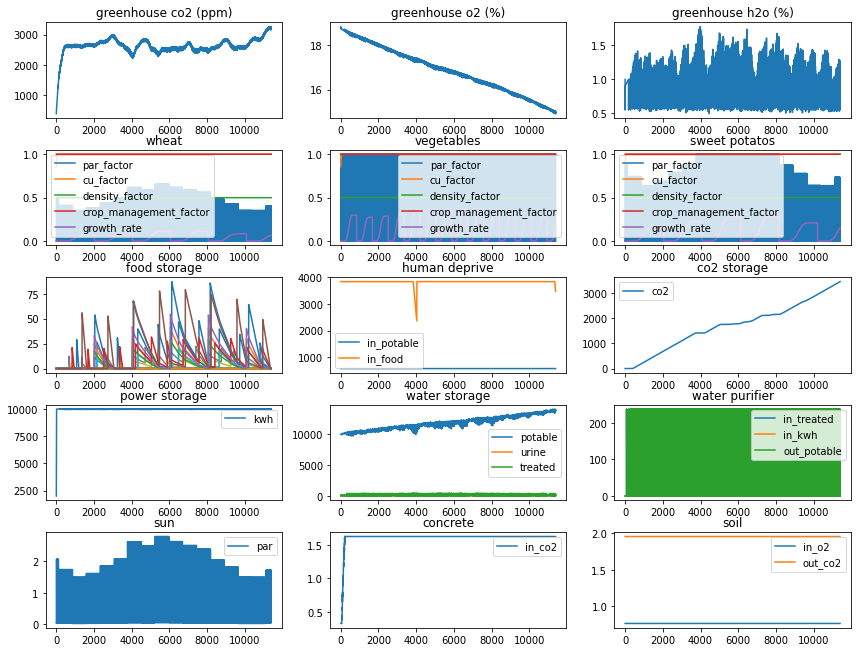

In [10]:
# MISSION 1A
# Update config
start_1a = '1991-09-26'
end_1a = '1993-01-12'  # Day 475, pure O2 added
days_1a = pd.date_range(start_1a, end_1a, freq='D').shape[0]
config_b2_mission1a = {
    **deepcopy(config_b2_base),
    'start_time': start_1a,
    'termination': [{'condition': 'time', 'value': days_1a, 'unit': 'day',}],
}
with open(data_files_path / 'config_b2_mission1a.json', 'w') as f:
    json.dump(config_b2_mission1a, f, indent=4)

# Run Model
print('Mission 1a')
start_time = time.time()
model_1a = AgentModel.from_config(config_b2_mission1a, agent_desc=b2_agent_desc)
model_1a.step_to(termination=True)
runtime = round(time.time() - start_time, 2)
data_1a = model_1a.get_data()
with open(data_files_path / 'simdata_b2_mission1a.json', 'w') as f:
    json.dump(data_1a, f)

# Print Results
print(f'{model_1a.step_num} steps in {runtime}s, '
      f'from {model_1a.start_time} to {model_1a.start_time + model_1a.time}')
for agent in model_1a.scheduler.agents:
    if hasattr(agent, 'cause_of_death'):
        print(f'{agent.agent_type} died: {agent.cause_of_death}')        
plot_b2_data(data_1a)

## Mission 1b
- `config_b2_mission1b` + `.json`
- `model_1b`
- `data_1b`

Mission 1b
6168 steps in 31.31s, from 1993-01-12 00:00:00 to 1993-09-26 01:00:00


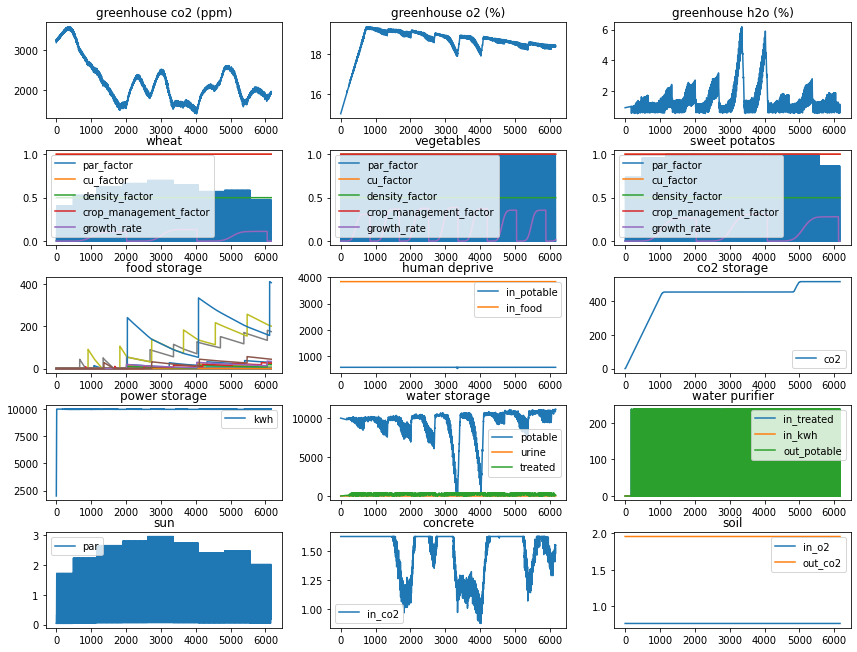

In [11]:
# MISSION 1b
# Update Config
start_1b = '1993-01-12'  # Day 475, pure O2 added
end_1b = '1993-09-25'  # 730 Days
days_1b = pd.date_range(start_1b, end_1b, freq='D').shape[0]
config_b2_mission1b = {
    **deepcopy(config_b2_base),
    'start_time': start_1b,
    'termination': [{'condition': 'time', 'value': days_1b, 'unit': 'day',}],
}
config_b2_mission1b['agents']['o2_storage']['o2'] = 441 * molar_mass['o2'] # Severinghaus Table 2
config_b2_mission1b['agents']['o2_storage']['o2'] *= 1.6 # Required to reach 20% o2 in greenhouse
# Update habitat storages to end of mission1a.
greenhouse_storage = parse_data(data_1a, ['greenhouse_b2', 'storage', '*', model_1a.step_num-1])
habitat_storage = parse_data(data_1a, ['crew_habitat_b2', 'storage', '*', model_1a.step_num-1])
biomes_storage = parse_data(data_1a, ['b2_biomes', 'storage', '*', model_1a.step_num-1])
config_b2_mission1b['agents']['greenhouse_b2'].update(greenhouse_storage)
config_b2_mission1b['agents']['crew_habitat_b2'].update(habitat_storage)
config_b2_mission1b['agents']['b2_biomes'].update(biomes_storage)
# Update greenhouse configuration
# p214: "By the last quarter of Mission 1, approximately 65% of the 
# agricultural area was planted in only three crops: beet, sweet potato 
# and lab-lab bean."
mission_2_staple_ratio = 0.65
mission_2_staple_plants = {'red_beet', 'sweet_potato', 'dry_bean'}
plant_agents = [a for a in config_b2_mission1b['agents'] if a in agent_desc['plants']]
plant_areas = {a: config_b2_mission1b['agents'][a]['amount'] for a in plant_agents}
total_area = sum(plant_areas.values())
amount_per_staple_plant = total_area * mission_2_staple_ratio / len(mission_2_staple_plants)
area_other_plants = sum(v for k, v in plant_areas.items() if k not in mission_2_staple_plants)
area_other_target = total_area * (1 - mission_2_staple_ratio)
scale_other_plants = area_other_target / area_other_plants
for plant in mission_2_staple_plants:
    config_b2_mission1b['agents'][plant] = {'amount': round(amount_per_staple_plant)}
for plant, area in plant_areas.items():
    if plant in mission_2_staple_plants:
        continue
    config_b2_mission1b['agents'][plant] = {'amount': round(area * scale_other_plants)}
# Update crop management factor (double)
b2_agent_desc_1b = deepcopy(b2_agent_desc)
with open(data_files_path / 'config_b2_mission1b.json', 'w') as f:
    json.dump(config_b2_mission1b, f, indent=4)

# Run Model
print('Mission 1b')
start_time = time.time()
model_1b = AgentModel.from_config(config_b2_mission1b, agent_desc=b2_agent_desc)
model_1b.step_to(termination=True)
runtime = round(time.time() - start_time, 2)
data_1b = model_1b.get_data()
with open(data_files_path / 'simdata_b2_mission1b.json', 'w') as f:
    json.dump(data_1b, f)

# Print Results
print(f'{model_1b.step_num} steps in {runtime}s, '
      f'from {model_1b.start_time} to {model_1b.start_time + model_1b.time}')
for agent in model_1b.scheduler.agents:
    if hasattr(agent, 'cause_of_death'):
        print(f'{agent.agent_type} died: {agent.cause_of_death}')
plot_b2_data(data_1b)

## Mission 2
- `config_b2_mission2` + `.json`
- `model_2`
- `data_2`

Mission 2
4440 steps in 21.06s, from 1994-03-06 00:00:00 to 1994-09-07 01:00:00


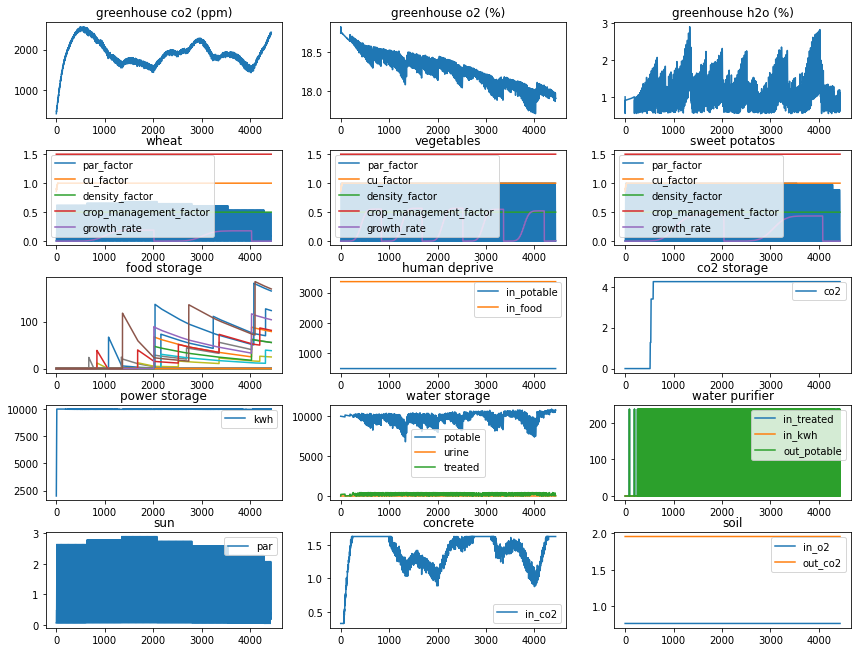

In [12]:
# MISSION 2
# Update Config
start_2 = '1994-03-06'
end_2 = '1994-09-06'
days_2 = pd.date_range(start_2, end_2, freq='D').shape[0]
config_b2_mission2 = {
    **deepcopy(config_b2_base),
    'start_time': start_2,
    'termination': [{'condition': 'time', 'value': days_2, 'unit': 'day',}],
}
config_b2_mission2['agents']['human_agent']['amount'] = 7
with open(data_files_path / 'config_b2_mission2.json', 'w') as f:
    json.dump(config_b2_mission2, f, indent=4)
# Add crop management factor
b2_agent_desc_m2 = deepcopy(b2_agent_desc)
crop_mgmt_char = {'type': 'crop_management_factor', 'value': 1.5}
for plant, plant_desc in b2_agent_desc_m2['plants'].items():
    if not any(v['type'] == 'crop_management_factor' for v in plant_desc['data']['characteristics']):
        b2_agent_desc_m2['plants'][plant]['data']['characteristics'].append(crop_mgmt_char)
    
# Run Model
print('Mission 2')
start_time = time.time()
model_2 = AgentModel.from_config(config_b2_mission2, agent_desc=b2_agent_desc_m2)
model_2.step_to(termination=True)
runtime = round(time.time() - start_time, 2)
data_2 = model_2.get_data()
with open(data_files_path / 'simdata_b2_mission2.json', 'w') as f:
    json.dump(data_2, f)

# Display results
print(f'{model_2.step_num} steps in {runtime}s, '
      f'from {model_2.start_time} to {model_2.start_time + model_2.time}')
for agent in model_2.scheduler.agents:
    if hasattr(agent, 'cause_of_death'):
        print(f'{agent.agent_type} died: {agent.cause_of_death}')
plot_b2_data(data_2)

## Compare to Research Data
(from October)

In [13]:
# Daily o2 and co2 data for mission 1 is available from Severinghaus figure 1
fnames = [('o2', 'severinghaus_o2_datapoints.csv'), 
          ('co2', 'severinghaus_co2_datapoints.csv'),
          ('co2_in_scrubber', 'severinghaus_co2_offset_datapoints.csv')]
mission_1a_start_date = '1991-09-26'
daily_o2_co2 = pd.DataFrame([])
for var, fname in fnames:
    df = pd.read_csv(b2_data_path / fname, header=None)
    df.columns = ['julian', 'value']
    df['label'] = var
    df['timestamp'] = pd.to_datetime(mission_1a_start_date)  # Create timestamp column
    time_delta = pd.to_timedelta(df['julian'], unit='D')  # julian -> timedelta
    df['timestamp'] += time_delta  # Add timedelta to timestamp
    del df['julian']
    daily_o2_co2 = pd.concat([daily_o2_co2, df], axis=0)  # Add to all records
daily_o2_co2.set_index('timestamp', inplace=True)
print('Daily o2 and co2 data:', daily_o2_co2.shape, daily_o2_co2['label'].unique())

# Table 1: Known inputs and outputs
cols = ['description', 'o2_kmoles', 'o2_uncertainty', 'co2_kmoles', 'co2_uncertainty']
data = [('Air added on day 75', 126, 4, 0, 0),
        ('Air dumped on day 474', -31, 2, -1, 1),
        ('Pure O2 added on days 475-494', 441, 8, 0, 0),
        ('Total CO2 taken up by scrubber', 0, 0, -98, 10),
        ('Estimated net leakage', 2, 24, -2, 1),
        ('Soil Respiration', -708, 27, 662, 40),
        ('Concrete Calcification', 0, 0, -550, 38),]
aggregate_flows = pd.DataFrame(data, columns=cols)
print('Aggregate o2 and co2 flows:', aggregate_flows.shape)

# --------
# Marino et. al. The Agricultural biome of Biosphere 2: Structure, 
# composition and function
# --------

# Page 202: Design and description
iab_soil_volume = 2_000  # m2
cols = ['plot', 'area', 'crop']
data = [
    # Plot, area, crop
    (1, 69, 'Rice/Azalia/Tilapia'),
    (2, 56, 'Wheat'),
    (3, 55, 'Sorghum'),
    (4, 45, 'Peanut/Corn'),
    (5, 40, 'Beans'),
    (6, 52, 'Sweet Potato'),
    (7, 54, 'Sweet Potato'),
    (8, 50, 'Beans'),
    (9, 60, 'Vegetables'),
    (10, 89, 'Rice/Azalia/Tilapia'),
    (11, 81, 'Soybeans'),
    (12, 88, 'Corn'),
    (13, 94, 'Wheat'),
    (14, 81, 'Vegetables'),
    (15, 78, 'Rice'),
    (16, 83, 'Upland Rice/Corn'),
    (17, 102, 'Soybean/Sorghum'),
    (18, 92, 'Peanut/Corn'),
]
greenhouse_layout = pd.DataFrame(data, columns=cols)
greenhouse_layout.set_index('plot', inplace=True)
print('Greenhouse Layout:', greenhouse_layout.shape)

# p214: "By the last quarter of Mission 1, approximately 65% of the 
# agricultural area was planted in only three crops: beet, sweet potato 
# and lab-lab bean."
mission_2_staple_ratio = 0.65

# Page 220: Comparisons of plant productivity for selected IAB and CELSS crops
cols = ['mission', 'wheat', 'rice', 'corn', 'sorghum']
data = [('1a', 0.0017, 0.0023, 0, 0.0017),
       ('1b', .0012, 0.0016, 0, 0.0016),
       ('2', 0.003, 0.006, 0.0039, 0.0038)]
production_rates = pd.DataFrame(data, columns=cols)
print('Production Rates:', production_rates.shape, production_rates.columns)

Daily o2 and co2 data: (159, 2) ['o2' 'co2' 'co2_in_scrubber']
Aggregate o2 and co2 flows: (7, 5)
Greenhouse Layout: (18, 2)
Production Rates: (3, 5) Index(['mission', 'wheat', 'rice', 'corn', 'sorghum'], dtype='object')


In [ ]:
# Atmosphere
for mission in ('1a', '1b', '2'):
    start_date = {
        '1a': '1991-09-26',
        '1b': '1993-01-12',
        '2': '1993-09-25',
    }[mission]
    data = {
        '1a': data_1a,
        '1b': data_1b,
        '2': data_2,
    }[mission]
    n_steps = len(data['greenhouse_b2']['age'])
    timesteps = pd.date_range(start_date, periods=n_steps, freq='H')
    def to_timesteps(df, value_col='percent'):
        """Return interpolated timestep values from a df of timestamped values"""
        ts = pd.DataFrame([], index=timesteps)  # Create a new df with timestep index
        for col in df.columns:
            ts[col] = df.loc[df.index[0], col]  # Fill with copies of the df[0]

        vals = ts[value_col].to_numpy()
        for i, row in df.iterrows():
            # Find the nearest timestep for every datapoint
            i_ts = ts.index.get_indexer([i], method='nearest')[0]
            # Set that step and all future steps to itself
            vals[i_ts:] = row[value_col]    
        ts[value_col] = vals
        return ts

    # 3-panel: o2, co2, co2 in scrubber
    fig, axs = plt.subplots(1, 3, figsize=(12, 2.5))
    fig.tight_layout(rect=[0, 0.03, 1, 0.9])
    fig.suptitle(f'Mission {mission}: Oxygen and CO2 history (Severinghaus Figure 1)')
    for i, field in enumerate(daily_o2_co2['label'].unique()):

        # Put the model data in a dataframe with a time axis
        if field == 'co2_in_scrubber':
            simulated = np.array(data['co2_storage']['storage']['co2'])
            # Divide by the total starting mass of greenhouse_b2 for percentage
            greenhouse_atmosphere = sum([data['greenhouse_b2']['storage'][currency][0]
                                         for currency in data['greenhouse_b2']['storage']])
            simulated /= greenhouse_atmosphere
        else:
            simulated = np.array(data['greenhouse_b2']['storage_ratios'][field])
        # TODO: Convert kg ratio to mole ratio
        sim_ts = pd.DataFrame(simulated, index=timesteps, columns=['percent'])
        sim_ts['label'] = 'simulated'

        # Select sample data for mission
        actual = daily_o2_co2[daily_o2_co2['label'] == field]
        actual = actual[actual.index <= timesteps[-1]]  # Set range
        act_raw = pd.DataFrame(actual['value'].to_numpy(), 
                               index=actual.index, columns=['percent'])
        act_raw['label'] = 'actual'
        act_ts = to_timesteps(act_raw)

        # Plot both on the axis
        df = pd.concat([sim_ts, act_ts], axis=0)
        df.groupby('label').percent.plot(legend=True, title=field, ax=axs[i])

In [ ]:
# Aggregate gas flows
actual = pd.DataFrame(aggregate_flows['description'])
actual['o2'] = aggregate_flows['o2_kmoles'] * molar_mass['o2']
actual['co2'] = aggregate_flows['co2_kmoles'] * molar_mass['co2']
# Reference variable is for 620 days. This is equivalent to
# Mission 1a (474 days) + the first 146 days of Mission 1b.
n_days = 620
mission_1b_cutoff_day = 146 * 24
print(f'Aggregate Gas Flows, Mission 1a + Mission 1b thru day '
      f'{mission_1b_cutoff_day} ({n_days} days, Severinghaus Table 1)\n')

# 'Air added on day 75' (ignore)
# 'Air dumped on day 474' (ignore)
# 'Pure O2 added on days 475-494'
#   Equivalent to 'the first 19 days of Mission 1b'
n_steps = 19 * 24
path = ['o2_makeup_valve', 'flows', 'out', 'o2', 'SUM', f'0:{n_steps}']
total_o2_added = sum(parse_data(data_1b, path))
print('Pure O2 added on days 475-494', 
      '\t| Actual:', round(actual.loc[2, 'o2'], 2),
      '\t| Simulated:', round(total_o2_added, 2))

# 'Total CO2 taken up by scrubber'
#   Equivalent to the ending co2_storage.storage.co2 value
#   plus the same value in mission 1b at the cutoff day.
path = ['co2_storage', 'storage', 'co2', '*']
mission_1a_scrubbed = parse_data(data_1a, path)[-1]
path[3] = mission_1b_cutoff_day
mission_1b_scrubbed = parse_data(data_1b, path)
print('Total CO2 taken up by scrubber', 
      '\t| Actual:', round(actual.loc[3, 'co2'], 2),
      '\t| Simulated:', -round(mission_1a_scrubbed + mission_1b_scrubbed, 2))

# 'Soil Respiration'
#   The sum of all o2 and co2 values for soil
path = ['soil', 'flows', '*', 'o2,co2', 'SUM', '*']
mission_1a_respiration = parse_data(data_1a, path)
path[5] = f'0:{mission_1b_cutoff_day}'
mission_1b_respiration = parse_data(data_1b, path)
o2_1a = sum(mission_1a_respiration['in']['o2'])
co2_1a = sum(mission_1a_respiration['out']['co2'])
o2_1b = sum(mission_1b_respiration['in']['o2'])
co2_1b = sum(mission_1b_respiration['out']['co2'])
respiration = {
    'o2': o2_1a + o2_1b,
    'co2': co2_1a + co2_1b,
}
print('Soil Respiration O2\t', 
      '\t| Actual:', round(actual.loc[5, 'o2'], 2),
      '\t| Simulated:', -round(respiration['o2'], 2))
print('Soil Respiration CO2\t', 
      '\t| Actual:', round(actual.loc[5, 'co2'], 2),
      '\t| Simulated:', round(respiration['co2'], 2))

# 'Concrete Calcification'
path = ['concrete', 'flows', 'in', 'co2', 'SUM', '*']
mission_1a_concrete = sum(parse_data(data_1a, path))
path[5] = f'0:{mission_1b_cutoff_day}'
mission_1b_concrete = sum(parse_data(data_1b, path))
print('Concrete Calcification CO2', 
      '\t| Actual:', actual.loc[6, 'co2'],
      '\t| Simulated:', -round(mission_1a_concrete + mission_1b_concrete, 2))

In [ ]:
# Greenhouse layout
actual = {ref[0]: ref[1] for ref in greenhouse_reference}
simulated_1a = {a: d['full_amount'] for a, d in data_1a.items() 
                if isinstance(d, dict) and 'growth' in d}
simulated_1b = {a: d['full_amount'] for a, d in data_1b.items() 
                if isinstance(d, dict) and 'growth' in d}
all_crops = set(actual.keys())
all_crops.update(set(simulated_1a.keys()))
all_crops.update(set(simulated_1b.keys()))
all_crops = list(all_crops)

fig, ax = plt.subplots(figsize=(4, 5))
labels = ['actual', 'simulated 1a', 'simulated 1b']
bottom = np.array([0, 0, 0])
for i, crop in enumerate(all_crops):
    _actual = actual.get(crop, 0)
    _simulated_1a = simulated_1a.get(crop, 0)
    _simulated_1b = simulated_1b.get(crop, 0)
    values = np.array([_actual, _simulated_1a, _simulated_1b])
    label = f'{crop}'
    ax.bar(labels, values, label=label, bottom=bottom, width=0.5, align='center')
    bottom += values
    
# Need to reverse the axis for some reason
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel('m2')
ax.set_title('Greenhouse Layout')

In [ ]:
actual = production_rates.copy()        

mission_data = {
    '1a': data_1a,
    '1b': data_1b,
    '2': data_2,
}
simulated = pd.DataFrame(mission_data.keys(), columns=['mission'])
simulated.head()
productivity_crops = ('wheat', 'rice', 'corn', 'sorghum')

n_steps = {'1a': 11400, '1b': 6168, '2': 4440}

for crop in productivity_crops:
    crop_values = []
    path = [crop, 'flows', 'out', crop, 'SUM', '*']
    for i, (mission, simdata) in enumerate(mission_data.items()):
        if crop not in simdata:
            value = 0
        else:
            production = parse_data(simdata, path)
            value = sum(production) / simdata[crop]['full_amount']
            lifetime = next(char['value'] for char in agent_desc['plants'][crop]['data']['characteristics']
                            if char['type'] == 'lifetime')
            value /= (n_steps[mission] / 24)
        crop_values.append(value)
    simulated[crop] = crop_values

print('Plant Productivity, kg/m2-day (Marino Table 3)\n')
print('Actual:')
print(actual.head())
print('\nSimulated:')
print(simulated.head())

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot kcal/kg for all plants in store
# Calculate food storage ratios
plants = [a.agent_type for a in model_1a.get_agents_by_class('plants')]
plants_index = ','.join(p for p in plants)
food_storage = parse_data(data_1a, ['food_storage', 'storage', plants_index, '*'])
kcal_per_kg = {}
n_steps = len(next(iter(food_storage.values())))
total_storage = []
for i in range(n_steps):
    total_storage.append(sum(v[i] for v in food_storage.values()))
total_storage = np.array(total_storage)
storage_ratios = {k: np.array(v)/total_storage for k, v in food_storage.items()}
# Find the kcal per kg for each timestep
kcal_ref = {p: currency_desc['food'][p]['nutrition']['kcal'] for p in plants}
kcals_per_kg = np.zeros(total_storage.shape[0])
for crop, ratios in storage_ratios.items():
    kcals_per_kg += storage_ratios[crop] * kcal_ref[crop]
# Convert to weekly mean and plot
kcals_per_kg_daily = np.zeros(kcals_per_kg.shape[0]//24)
for day in range(kcals_per_kg_daily.shape[0]):
    start = day * 24
    end = min((day + 1) * 24, kcals_per_kg.shape[0])
    kcals_per_kg_daily[day] = np.mean(kcals_per_kg[start:end])   
axs[0].set_title('mean daily kcal per kg in food storage')
axs[0].plot(kcals_per_kg_daily)
    
# Plot actual kcal/day throughout mission
default_target = next(i['value'] for i in agent_desc['inhabitants']['human_agent']['data']['input']
                    if i['type'] == 'food') * 24
actual_target = model_1a.get_agents_by_type('human_agent')[0].attrs['in_food'] * 24
print(f'Default food target: {default_target}kg; Simulated target: {round(actual_target, 2)}kg')
actual_rate = parse_data(data_1a, ['human_agent', 'flows', 'in', plants_index, 'SUM', '*'])
actual_kcal = {k: np.array(v)*kcal_ref[k] for k, v in actual_rate.items()}
total_kcal = np.zeros(n_steps)
for values in actual_kcal.values():
    total_kcal += np.array(values)
n_crew = np.array(parse_data(data_1a, ['human_agent', 'amount', '*']))
kcals_per_human_daily = np.zeros(n_steps//24)
for day in range(kcals_per_human_daily.shape[0]):
    start = day * 24
    end = min((day + 1) * 24, n_steps)
    kcals_per_human_daily[day] = np.sum(total_kcal[start:end]) / n_crew[start]

axs[1].set_title('simulated kcal/crew-day')
# axs[1].axhline(default_target, label='default target')
# axs[1].axhline(actual_target, label='actual target') 
axs[1].plot(kcals_per_human_daily, label='actual_rate')

mean_daily = np.mean(kcals_per_human_daily[kcals_per_human_daily != 0.])
axs[1].axhline(mean_daily, label=f'Mean={round(mean_daily)}', color='red')
axs[1].legend()